## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [4]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

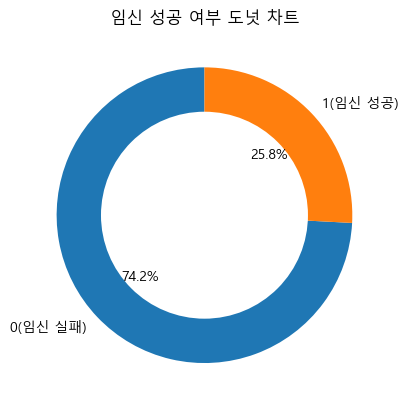

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [7]:
# '시술_시기_코드' 변수의 값이 'TRVNRY'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRVNRY'] 
IVF_test = test[test['시술_시기_코드'] == 'TRVNRY']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [8]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRVNRY    0.740221  0.259779  26776  9397  36173


In [9]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [10]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
만18-34세   0.673471  0.326529  10063.0  4879.0  14942
만35-37세   0.727938  0.272062   5865.0  2192.0   8057
만38-39세   0.785221  0.214779   4431.0  1212.0   5643
만40-42세   0.841521  0.158479   4248.0   800.0   5048
만43-44세   0.896422  0.103578   1428.0   165.0   1593
만45-50세   0.826340  0.173660    709.0   149.0    858
알 수 없음    1.000000  0.000000     32.0     0.0     32


In [11]:
test['시술_당시_나이'].value_counts()

만18-34세    5205
만35-37세    2808
만38-39세    1896
만40-42세    1783
만43-44세     545
만45-50세     311
알 수 없음       12
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [12]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       1.000000  0.000000    1.0   0.0      1
2.0       1.000000  0.000000    4.0   0.0      4
3.0       1.000000  0.000000    5.0   0.0      5
4.0       0.666667  0.333333    4.0   2.0      6
5.0       0.680000  0.320000   17.0   8.0     25
6.0       0.786667  0.213333   59.0  16.0     75
7.0       0.808219  0.191781  118.0  28.0    146
8.0       0.827778  0.172222  149.0  31.0    180
9.0       0.810256  0.189744  158.0  37.0    195
10.0      0.834225  0.165775  156.0  31.0    187
11.0      0.862385  0.137615   94.0  15.0    109
12.0      0.788889  0.211111   71.0  19.0     90
13.0      0.753425  0.246575   55.0  18.0     73
14.0      0.720000  0.280000   36.0  14.0     50
15.0      0.821429  0.178571   23.0   5.0     28
16.0      0.870968  0.129032   27.0   4.0     31
17.0      0.800000  0.200000   16.0   4.0     20
18.0      0.933333  0.06666

In [13]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [14]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0-2년      1.000000  0.000000      5.0     0.0      5
3-5년      0.722222  0.277778     26.0    10.0     36
6-8년      0.812968  0.187032    326.0    75.0    401
9-11년     0.830957  0.169043    408.0    83.0    491
12-14년    0.760563  0.239437    162.0    51.0    213
15-17년    0.835443  0.164557     66.0    13.0     79
18-20년    0.882353  0.117647     30.0     4.0     34
unknown   0.737612  0.262388  25753.0  9161.0  34914


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [15]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.877426  0.122574    859   120    979
IVF       0.736404  0.263596  25917  9277  35194


In [16]:
test['시술_유형'].value_counts()

IVF    12201
DI       359
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [17]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                 group  '임신_성공_여부' count     ratio  Total
0                 GIFT                 0  0.000000      1
1           Generic DI                 2  0.333333      6
2                  ICI                 1  0.066667     15
3                 ICSI              4938  0.275235  17941
4            ICSI / AH                 3  0.065217     46
5   ICSI / BLASTOCYST                 32  0.244275    131
6            ICSI:ICSI                 4  0.026846    149
7             ICSI:IVF                27  0.232759    116
8         ICSI:Unknown                 3  0.157895     19
9                  IUI               117  0.122257    957
10                 IVF              3527  0.269175  13103
11            IVF / AH                 5  0.192308     26
12    IVF / BLASTOCYST                32  0.260163    123
13            IVF:ICSI                20  0.370370     54
14             IVF:IVF                 1  0.008621    116
15         IVF:Unknown                 5  0.500000

In [18]:
test['특정_시술_유형'].value_counts()

ICSI                  6151
IVF                   4629
Unknown               1161
IUI                    352
ICSI:ICSI               55
IVF:IVF                 43
IVF / BLASTOCYST        38
ICSI:IVF                35
ICSI / BLASTOCYST       35
IVF:ICSI                22
ICSI / AH               15
IVF / AH                10
ICSI:Unknown             4
ICI                      4
IVF:Unknown              3
Generic DI               3
Name: 특정_시술_유형, dtype: int64

In [19]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [20]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [21]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.666667  0.333333      4.0     2.0      6
ICI                0.933333  0.066667     14.0     1.0     15
ICSI               0.727188  0.272812  13253.0  4972.0  18225
ICSI / AH          0.934783  0.065217     43.0     3.0     46
ICSI / BLASTOCYST  0.755725  0.244275     99.0    32.0    131
IUI                0.877743  0.122257    840.0   117.0    957
IVF                0.732515  0.267485   9730.0  3553.0  13283
IVF / AH           0.807692  0.192308     21.0     5.0     26
IVF / BLASTOCYST   0.739837  0.260163     91.0    32.0    123
IVI                1.000000  0.000000      1.0     0.0      1
Unknown            0.797499  0.202501   2678.0   680.0   3358


In [22]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 6245
IVF                  4697
Unknown              1161
IUI                   352
IVF / BLASTOCYST       38
ICSI / BLASTOCYST      35
ICSI / AH              15
IVF / AH               10
ICI                     4
Generic DI              3
Name: 변환된_특정_시술_유형, dtype: int64

In [23]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [24]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                               group  '임신_성공_여부' count     ratio  Total
0           (Generic DI, 0, 0, 0, 0)                 2  0.333333      6
1                  (ICI, 0, 0, 0, 0)                 1  0.066667     15
2                 (ICSI, 1, 0, 0, 0)              4938  0.275235  17941
3            (ICSI / AH, 1, 0, 1, 0)                 3  0.065217     46
4   (ICSI / BLASTOCYST , 1, 0, 0, 1)                32  0.244275    131
5            (ICSI:ICSI, 1, 0, 0, 0)                 4  0.026846    149
6             (ICSI:IVF, 1, 0, 0, 0)                27  0.232759    116
7         (ICSI:Unknown, 1, 0, 0, 0)                 3  0.157895     19
8                  (IUI, 0, 0, 0, 0)               117  0.122257    957
9                  (IVF, 0, 1, 0, 0)              3527  0.269175  13103
10            (IVF / AH, 0, 1, 1, 0)                 5  0.192308     26
11    (IVF / BLASTOCYST, 0, 1, 0, 1)   

In [25]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [26]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.777922  0.222078   6004  1714   7718
1         0.729985  0.270015  20771  7683  28454


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [27]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1      0     1  Total
variable                                          
기록되지 않은 시행  0.727312  0.272688  20300  7611  27911
알 수 없음      0.783803  0.216197   6475  1786   8261


In [28]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    9665
알 수 없음        2895
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [29]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.761850  0.238150  21152  6612  27764
1.0       0.641271  0.358729   4764  2665   7429


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [30]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.806034  0.193966  187  45    232


In [31]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 35940
결측값 개수: 0


In [32]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.739789  0.260211  26588  9352  35940
1.0       0.806034  0.193966    187    45    232


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [33]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.736334  0.263666  25634  9179  34813
1.0       0.742105  0.257895    282    98    380


In [34]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9134  0.264133  34581
1  (0.0, 1.0)                45  0.193966    232
2  (1.0, 0.0)                98  0.257895    380


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [35]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738080  0.261920  25959  9212  35171
1         0.815185  0.184815    816   185   1001


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [36]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.739110  0.260890  26401  9319  35720
1         0.827434  0.172566    374    78    452


In [37]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9134  0.263084  34719
1  (0, 1)                78  0.172566    452
2  (1, 0)               185  0.184815   1001


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [38]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.737761  0.262239  25891  9203  35094
1         0.820037  0.179963    884   194   1078


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [39]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.739313  0.260687  26426  9318  35744
1         0.815421  0.184579    349    79    428


In [40]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9124  0.263197  34666
1  (0, 1)                79  0.184579    428
2  (1, 0)               194  0.179963   1078


In [41]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)              9122  0.263185  34660
1  (0, 0, 0, 1)                 2  0.181818     11
2  (0, 0, 1, 0)                10  0.208333     48
3  (0, 1, 0, 0)                 1  0.500000      2
4  (0, 1, 0, 1)                54  0.173633    311
5  (0, 1, 1, 0)                23  0.165468    139
6  (1, 0, 0, 0)                 1  0.250000      4
7  (1, 0, 0, 1)                23  0.216981    106
8  (1, 0, 1, 0)               161  0.180696    891


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [42]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738004  0.261996  25839  9173  35012
1         0.806897  0.193103    936   224   1160


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [43]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.739258  0.260742  26512  9351  35863
1         0.851133  0.148867    263    46    309


In [44]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              9127  0.262988  34705
1  (0, 1)                46  0.149837    307
2  (1, 0)               224  0.193437   1158
3  (1, 1)                 0  0.000000      2


In [45]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              9121  0.263172  34658
1   (0, 0, 0, 0, 0, 1)                 0  0.000000      1
2   (0, 0, 0, 0, 1, 0)                 1  1.000000      1
3   (0, 0, 0, 1, 0, 0)                 1  0.166667      6
4   (0, 0, 0, 1, 0, 1)                 0  0.000000      3
5   (0, 0, 0, 1, 1, 0)                 1  0.500000      2
6   (0, 0, 1, 0, 0, 0)                 4  0.114286     35
7   (0, 0, 1, 0, 1, 0)                 6  0.461538     13
8   (0, 1, 0, 0, 0, 1)                 0  0.000000      1
9   (0, 1, 0, 0, 1, 0)                 1  1.000000      1
10  (0, 1, 0, 1, 0, 0)                 0  0.000000      1
11  (0, 1, 0, 1, 0, 1)                44  0.164794    267
12  (0, 1, 0, 1, 1, 0)                10  0.238095     42
13  (0, 1, 0, 1, 1, 1)                 0  0.000000      1
14  (0, 1, 1, 0, 0, 0)                 1  1.00

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [46]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.739742  0.260258  20391  7174  27565
1         0.741722  0.258278   6384  2223   8607


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [47]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738675  0.261325  22797  8065  30862
1         0.749153  0.250847   3978  1332   5310


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [48]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.751321  0.248679  16774  5552  22326
1         0.722302  0.277698  10001  3845  13846


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [49]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.744916  0.255084  23479  8040  31519
1         0.708360  0.291640   3296  1357   4653


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [50]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740213  0.259787  26775  9397  36172


In [51]:
test['불임_원인_-_여성_요인'].value_counts()

0    12560
Name: 불임_원인_-_여성_요인, dtype: int64

In [52]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [53]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740213  0.259787  26775  9397  36172


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [54]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.738565  0.261435  24722  8751  33473
1         0.760652  0.239348   2053   646   2699


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740175  0.259825  26744  9388  36132
1         0.775000  0.225000     31     9     40


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740213  0.259787  26775  9397  36172


In [57]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    12560
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [58]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [59]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740191  0.259809  26769  9396  36165
1         0.857143  0.142857      6     1      7


In [60]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740196  0.259804  26764  9394  36158
1         0.785714  0.214286     11     3     14


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [62]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    116.0     0.0    116
기증용, 난자 저장용          1.000000  0.000000      6.0     0.0      6
기증용, 배아 저장용          1.000000  0.000000     11.0     0.0     11
기증용, 배아 저장용, 현재 시술용  0.500000  0.500000      1.0     1.0      2
기증용, 현재 시술용          0.623028  0.376972    395.0   239.0    634
난자 저장용               1.000000  0.000000    202.0     0.0    202
난자 저장용, 배아 저장용       1.000000  0.000000      3.0     0.0      3
난자 저장용, 현재 시술용       1.000000  0.000000      1.0     0.0      1
배아 저장용               1.000000  0.000000    429.0     0.0    429
배아 저장용, 현재 시술용       1.000000  0.000000      2.0     0.0      2
현재 시술용               0.732530  0.267470  24750.0  9037.0  33787


In [63]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [64]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    116.0     0.0    116
기증용, 난자 저장용          1.000000  0.000000      6.0     0.0      6
기증용, 배아 저장용          1.000000  0.000000     11.0     0.0     11
기증용, 배아 저장용, 현재 시술용  0.500000  0.500000      1.0     1.0      2
기증용, 현재 시술용          0.623028  0.376972    395.0   239.0    634
난자 저장용               1.000000  0.000000    202.0     0.0    202
난자 저장용, 배아 저장용       1.000000  0.000000      3.0     0.0      3
난자 저장용, 현재 시술용       1.000000  0.000000      1.0     0.0      1
배아 저장용               1.000000  0.000000    429.0     0.0    429
배아 저장용, 현재 시술용       1.000000  0.000000      2.0     0.0      2
현재 시술용               0.732530  0.267470  24750.0  9037.0  33787


In [65]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용                 11726
기증용, 현재 시술용              201
배아 저장용                   142
난자 저장용                    76
기증용                       49
기증용, 배아 저장용                4
기증용, 난자 저장용                2
기증용, 배아 저장용, 현재 시술용        1
Name: 배아_생성_주요_이유, dtype: int64

In [66]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 979
결측값 개수: 0


In [67]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [68]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [69]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [70]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [71]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

           group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0)               120  0.122574    979
1   (0, 0, 0, 1)                 0  0.000000    429
2   (0, 0, 1, 0)                 0  0.000000    202
3   (0, 0, 1, 1)                 0  0.000000      3
4   (0, 1, 0, 0)                 0  0.000000    116
5   (0, 1, 0, 1)                 0  0.000000     11
6   (0, 1, 1, 0)                 0  0.000000      6
7   (1, 0, 0, 0)              9037  0.267470  33787
8   (1, 0, 0, 1)                 0  0.000000      2
9   (1, 0, 1, 0)                 0  0.000000      1
10  (1, 1, 0, 0)               239  0.376972    634
11  (1, 1, 0, 1)                 1  0.500000      2


In [72]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.931271  0.068729   1626   120   1746
1         0.730523  0.269477  25149  9277  34426


In [73]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [74]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.700291  0.299709  9143  3913  13056
1회        0.745295  0.254705  6098  2084   8182
2회        0.754895  0.245105  4472  1452   5924
3회        0.782395  0.217605  2862   796   3658
4회        0.768761  0.231239  1762   530   2292
5회        0.798831  0.201169   957   241   1198
6회 이상     0.795381  0.204619  1481   381   1862


In [75]:
test['총_시술_횟수'].value_counts()

0회       4453
1회       2838
2회       2049
3회       1313
4회        766
6회 이상     656
5회        485
Name: 총_시술_횟수, dtype: int64

In [76]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.700291  0.299709  9143  3913  13056
1         0.745295  0.254705  6098  2084   8182
2         0.754895  0.245105  4472  1452   5924
3         0.782395  0.217605  2862   796   3658
4         0.768761  0.231239  1762   530   2292
5         0.798831  0.201169   957   241   1198
6         0.795381  0.204619  1481   381   1862


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [77]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.707620  0.292380  12072  4988  17060
1회        0.755777  0.244223   6508  2103   8611
2회        0.769028  0.230972   3799  1141   4940
3회        0.789575  0.210425   2045   545   2590
4회        0.764664  0.235336   1069   329   1398
5회        0.814655  0.185345    567   129    696
6회 이상     0.815279  0.184721    715   162    877


In [78]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.707620  0.292380  12072  4988  17060
1         0.755777  0.244223   6508  2103   8611
2         0.769028  0.230972   3799  1141   4940
3         0.789575  0.210425   2045   545   2590
4         0.764664  0.235336   1069   329   1398
5         0.814655  0.185345    567   129    696
6         0.815279  0.184721    715   162    877


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [79]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.706022  0.293978  9837  4096  13933
1회        0.747868  0.252132  6315  2129   8444
2회        0.753655  0.246345  4433  1449   5882
3회        0.778545  0.221455  2707   770   3477
4회        0.770531  0.229469  1595   475   2070
5회        0.790698  0.209302   816   216   1032
6회 이상     0.803598  0.196402  1072   262   1334


In [80]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.706022  0.293978  9837  4096  13933
1         0.747868  0.252132  6315  2129   8444
2         0.753655  0.246345  4433  1449   5882
3         0.778545  0.221455  2707   770   3477
4         0.770531  0.229469  1595   475   2070
5         0.790698  0.209302   816   216   1032
6         0.803598  0.196402  1072   262   1334


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [81]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.737089  0.262911  25176  8980  34156
1회        0.823400  0.176600    373    80    453
2회        0.785563  0.214437    370   101    471
3회        0.774038  0.225962    322    94    416
4회        0.766667  0.233333    184    56    240
5회        0.816092  0.183908    142    32    174
6회 이상     0.793893  0.206107    208    54    262


In [82]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.737089  0.262911  25176  8980  34156
1         0.823400  0.176600    373    80    453
2         0.785563  0.214437    370   101    471
3         0.774038  0.225962    322    94    416
4         0.766667  0.233333    184    56    240
5         0.816092  0.183908    142    32    174
6         0.793893  0.206107    208    54    262


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [83]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.738023  0.261977  21151.0  7508.0  28659
1회        0.745882  0.254118   4890.0  1666.0   6556
2회        0.769499  0.230501    661.0   198.0    859
3회        0.736264  0.263736     67.0    24.0     91
4회        0.833333  0.166667      5.0     1.0      6
6회 이상     1.000000  0.000000      1.0     0.0      1


In [84]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.738023  0.261977  21151.0  7508.0  28659
1         0.745882  0.254118   4890.0  1666.0   6556
2         0.769499  0.230501    661.0   198.0    859
3         0.736264  0.263736     67.0    24.0     91
4         0.833333  0.166667      5.0     1.0      6
6         1.000000  0.000000      1.0     0.0      1


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [85]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.739247  0.260753  21501  7584  29085
1회        0.740890  0.259110   4595  1607   6202
2회        0.769712  0.230288    615   184    799
3회        0.740741  0.259259     60    21     81
4회        0.800000  0.200000      4     1      5


In [86]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.739247  0.260753  21501  7584  29085
1         0.740890  0.259110   4595  1607   6202
2         0.769712  0.230288    615   184    799
3         0.740741  0.259259     60    21     81
4         0.800000  0.200000      4     1      5


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [87]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.739270  0.260730  26406.0  9313.0  35719
1회        0.818408  0.181592    329.0    73.0    402
2회        0.772727  0.227273     34.0    10.0     44
3회        0.800000  0.200000      4.0     1.0      5
4회        1.000000  0.000000      1.0     0.0      1
5회        1.000000  0.000000      1.0     0.0      1


In [88]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.739270  0.260730  26406.0  9313.0  35719
1         0.818408  0.181592    329.0    73.0    402
2         0.772727  0.227273     34.0    10.0     44
3         0.800000  0.200000      4.0     1.0      5
4         1.000000  0.000000      1.0     0.0      1
5         1.000000  0.000000      1.0     0.0      1


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [89]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.739980  0.260020  22673.0  7967.0  30640
1회        0.739718  0.260282   3885.0  1367.0   5252
2회        0.771863  0.228137    203.0    60.0    263
3회        0.857143  0.142857     12.0     2.0     14
4회        0.500000  0.500000      1.0     1.0      2
6회 이상     1.000000  0.000000      1.0     0.0      1


In [90]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.739980  0.260020  22673.0  7967.0  30640
1         0.739718  0.260282   3885.0  1367.0   5252
2         0.771863  0.228137    203.0    60.0    263
3         0.857143  0.142857     12.0     2.0     14
4         0.500000  0.500000      1.0     1.0      2
6         1.000000  0.000000      1.0     0.0      1


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [91]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.740667  0.259333  22934  8030  30964
1회        0.735644  0.264356   3651  1312   4963
2회        0.775862  0.224138    180    52    232
3회        0.818182  0.181818      9     2     11
4회        0.500000  0.500000      1     1      2


In [92]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740667  0.259333  22934  8030  30964
1         0.735644  0.264356   3651  1312   4963
2         0.775862  0.224138    180    52    232
3         0.818182  0.181818      9     2     11
4         0.500000  0.500000      1     1      2


In [93]:
test['IVF_출산_횟수'].value_counts()

0    10670
1     1808
2       76
3        6
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [94]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.739599  0.260401  26505.0  9332.0  35837
1회        0.808442  0.191558    249.0    59.0    308
2회        0.760000  0.240000     19.0     6.0     25
3회        1.000000  0.000000      1.0     0.0      1
5회        1.000000  0.000000      1.0     0.0      1


In [95]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.739599  0.260401  26505.0  9332.0  35837
1         0.808442  0.191558    249.0    59.0    308
2         0.760000  0.240000     19.0     6.0     25
3         1.000000  0.000000      1.0     0.0      1
5         1.000000  0.000000      1.0     0.0      1


In [96]:
test['DI_출산_횟수'].value_counts()

0    12446
1      109
2        5
Name: DI_출산_횟수, dtype: int64

In [97]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [98]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [99]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [100]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.848169  0.151831  6022.0  1078.0   7100
1.0       0.901505  0.098495  1977.0   216.0   2193
2.0       0.814061  0.185939  2281.0   521.0   2802
3.0       0.748562  0.251438  2343.0   787.0   3130
4.0       0.727856  0.272144  2268.0   848.0   3116
5.0       0.690102  0.309898  2022.0   908.0   2930
6.0       0.677587  0.322413  1820.0   866.0   2686
7.0       0.648366  0.351634  1488.0   807.0   2295
8.0       0.650368  0.349632  1237.0   665.0   1902
9.0       0.647536  0.352464  1038.0   565.0   1603
10.0      0.614238  0.385762   742.0   466.0   1208
11.0      0.628067  0.371933   640.0   379.0   1019
12.0      0.648582  0.351418   526.0   285.0    811
13.0      0.617450  0.382550   368.0   228.0    596
14.0      0.651452  0.348548   314.0   168.0    482
15.0      0.588556  0.411444   216.0   151.0    367
16.0      0.611111  0.388889   143

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [101]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.749602  0.250398  13199.0  4409.0  17608
1.0       0.928333  0.071667    557.0    43.0    600
2.0       0.903114  0.096886    783.0    84.0    867
3.0       0.823129  0.176871    968.0   208.0   1176
4.0       0.782178  0.217822   1106.0   308.0   1414
5.0       0.740268  0.259732   1103.0   387.0   1490
6.0       0.738665  0.261335   1173.0   415.0   1588
7.0       0.711929  0.288071   1122.0   454.0   1576
8.0       0.716927  0.283073   1008.0   398.0   1406
9.0       0.661995  0.338005    803.0   410.0   1213
10.0      0.671616  0.328384    769.0   376.0   1145
11.0      0.648128  0.351872    606.0   329.0    935
12.0      0.669065  0.330935    558.0   276.0    834
13.0      0.622781  0.377219    421.0   255.0    676
14.0      0.615955  0.384045    332.0   207.0    539
15.0      0.643777  0.356223    300.0   166.0    466
16.0      0.649

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [102]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.757932  0.242068  13808.0  4410.0  18218
1.0       0.904051  0.095949   1272.0   135.0   1407
2.0       0.812771  0.187229   1502.0   346.0   1848
3.0       0.748799  0.251201   1559.0   523.0   2082
4.0       0.729716  0.270284   1466.0   543.0   2009
5.0       0.686127  0.313873   1281.0   586.0   1867
6.0       0.678154  0.321846   1161.0   551.0   1712
7.0       0.645606  0.354394    889.0   488.0   1377
8.0       0.662326  0.337674    712.0   363.0   1075
9.0       0.630872  0.369128    564.0   330.0    894
10.0      0.593145  0.406855    398.0   273.0    671
11.0      0.610701  0.389299    331.0   211.0    542
12.0      0.674699  0.325301    280.0   135.0    415
13.0      0.627240  0.372760    175.0   104.0    279
14.0      0.665198  0.334802    151.0    76.0    227
15.0      0.565714  0.434286     99.0    76.0    175
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [103]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.999267  0.000733   4092     3   4095
1.0       0.700726  0.299274   8785  3752  12537
2.0       0.692299  0.307701  11857  5270  17127
3.0       0.824268  0.175732   1182   252   1434


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [104]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.770272  0.229728  14287  4261  18548
1.0       0.695023  0.304977   4469  1961   6430
2.0       0.690016  0.309984   6462  2903   9365
3.0       0.821176  0.178824    698   152    850


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [105]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.778890  0.221110  19371.0  5499.0  24870
1.0       0.630655  0.369345   1617.0   947.0   2564
2.0       0.596935  0.403065   1558.0  1052.0   2610
3.0       0.606822  0.393178   1014.0   657.0   1671
4.0       0.604970  0.395030    706.0   461.0   1167
5.0       0.635682  0.364318    424.0   243.0    667
6.0       0.625532  0.374468    294.0   176.0    470
7.0       0.695364  0.304636    210.0    92.0    302
8.0       0.720930  0.279070    155.0    60.0    215
9.0       0.782609  0.217391    108.0    30.0    138
10.0      0.760000  0.240000     76.0    24.0    100
11.0      0.849315  0.150685     62.0    11.0     73
12.0      0.860759  0.139241     68.0    11.0     79
13.0      0.903846  0.096154     47.0     5.0     52
14.0      0.900000  0.100000     36.0     4.0     40
15.0      0.937500  0.062500     30.0     2.0     32
16.0      0.91666

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [106]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.755669  0.244331  22327.0  7219.0  29546
1.0       0.631142  0.368858    989.0   578.0   1567
2.0       0.610613  0.389387    886.0   565.0   1451
3.0       0.610043  0.389957    571.0   365.0    936
4.0       0.587542  0.412458    349.0   245.0    594
5.0       0.635057  0.364943    221.0   127.0    348
6.0       0.578431  0.421569    118.0    86.0    204
7.0       0.709924  0.290076     93.0    38.0    131
8.0       0.743590  0.256410     87.0    30.0    117
9.0       0.838710  0.161290     52.0    10.0     62
10.0      0.893617  0.106383     42.0     5.0     47
11.0      0.805556  0.194444     29.0     7.0     36
12.0      0.948718  0.051282     37.0     2.0     39
13.0      1.000000  0.000000     25.0     0.0     25
14.0      1.000000  0.000000     16.0     0.0     16
15.0      1.000000  0.000000     16.0     0.0     16
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [107]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.725845  0.274155  21681.0  8189.0  29870
1.0       0.820280  0.179720   1173.0   257.0   1430
2.0       0.783800  0.216200   1287.0   355.0   1642
3.0       0.813785  0.186215    673.0   154.0    827
4.0       0.806202  0.193798    416.0   100.0    516
5.0       0.824104  0.175896    253.0    54.0    307
6.0       0.736842  0.263158    168.0    60.0    228
7.0       0.779817  0.220183     85.0    24.0    109
8.0       0.673469  0.326531     66.0    32.0     98
9.0       0.654545  0.345455     36.0    19.0     55
10.0      0.697674  0.302326     30.0    13.0     43
11.0      0.888889  0.111111     16.0     2.0     18
12.0      0.666667  0.333333     12.0     6.0     18
13.0      0.714286  0.285714      5.0     2.0      7
14.0      0.666667  0.333333      6.0     3.0      9
15.0      0.666667  0.333333      2.0     1.0      3
16.0      0.75000

### 47. 해동_난자_수

동결 해동된 난자의 수

In [108]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.736245  0.263755  25826.0  9252.0  35078
1.0       0.500000  0.500000      1.0     1.0      2
2.0       0.818182  0.181818      9.0     2.0     11
3.0       1.000000  0.000000      8.0     0.0      8
4.0       0.769231  0.230769     10.0     3.0     13
5.0       0.846154  0.153846     11.0     2.0     13
6.0       1.000000  0.000000      9.0     0.0      9
7.0       0.769231  0.230769     10.0     3.0     13
8.0       0.750000  0.250000     12.0     4.0     16
9.0       0.750000  0.250000      3.0     1.0      4
10.0      0.375000  0.625000      3.0     5.0      8
11.0      1.000000  0.000000      2.0     0.0      2
12.0      0.750000  0.250000      3.0     1.0      4
13.0      0.800000  0.200000      4.0     1.0      5
14.0      0.500000  0.500000      1.0     1.0      2
15.0      0.500000  0.500000      1.0     1.0      2
18.0      1.000000

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [109]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.774085  0.225915  5544.0  1618.0   7162
1.0       0.940276  0.059724   614.0    39.0    653
2.0       0.901895  0.098105   809.0    88.0    897
3.0       0.857143  0.142857   972.0   162.0   1134
4.0       0.823279  0.176721  1160.0   249.0   1409
5.0       0.784731  0.215269  1254.0   344.0   1598
6.0       0.787625  0.212375  1413.0   381.0   1794
7.0       0.745108  0.254892  1485.0   508.0   1993
8.0       0.731515  0.268485  1395.0   512.0   1907
9.0       0.707170  0.292830  1292.0   535.0   1827
10.0      0.706596  0.293404  1339.0   556.0   1895
11.0      0.685783  0.314217  1148.0   526.0   1674
12.0      0.671385  0.328615  1091.0   534.0   1625
13.0      0.662906  0.337094   940.0   478.0   1418
14.0      0.676798  0.323202   913.0   436.0   1349
15.0      0.679785  0.320215   760.0   358.0   1118
16.0      0.654737  0.345263   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [110]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.734180  0.265820  25617.0  9275.0  34892
1.0       1.000000  0.000000     11.0     0.0     11
2.0       1.000000  0.000000     20.0     0.0     20
3.0       1.000000  0.000000     18.0     0.0     18
4.0       1.000000  0.000000     28.0     0.0     28
5.0       1.000000  0.000000     25.0     0.0     25
6.0       1.000000  0.000000     32.0     0.0     32
7.0       1.000000  0.000000     16.0     0.0     16
8.0       1.000000  0.000000     24.0     0.0     24
9.0       0.941176  0.058824     16.0     1.0     17
10.0      1.000000  0.000000     19.0     0.0     19
11.0      0.923077  0.076923     12.0     1.0     13
12.0      1.000000  0.000000     18.0     0.0     18
13.0      1.000000  0.000000      7.0     0.0      7
14.0      1.000000  0.000000      9.0     0.0      9
15.0      1.000000  0.000000     10.0     0.0     10
16.0      1.00

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [111]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.823221  0.176779  5020.0  1078.0   6098
1.0       0.928817  0.071183   809.0    62.0    871
2.0       0.895498  0.104502  1114.0   130.0   1244
3.0       0.830446  0.169554  1342.0   274.0   1616
4.0       0.789074  0.210926  1560.0   417.0   1977
5.0       0.739328  0.260672  1628.0   574.0   2202
6.0       0.751064  0.248936  1765.0   585.0   2350
7.0       0.715045  0.284955  1749.0   697.0   2446
8.0       0.709633  0.290367  1547.0   633.0   2180
9.0       0.675553  0.324447  1343.0   645.0   1988
10.0      0.677807  0.322193  1298.0   617.0   1915
11.0      0.664842  0.335158  1093.0   551.0   1644
12.0      0.671642  0.328358   990.0   484.0   1474
13.0      0.634845  0.365155   798.0   459.0   1257
14.0      0.641544  0.358456   698.0   390.0   1088
15.0      0.663409  0.336591   611.0   310.0    921
16.0      0.649800  0.350200   488.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [112]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.796720  0.203280  6510.0  1661.0   8171
1.0       0.931904  0.068096   739.0    54.0    793
2.0       0.897527  0.102473  1016.0   116.0   1132
3.0       0.834117  0.165883  1242.0   247.0   1489
4.0       0.792818  0.207182  1435.0   375.0   1810
5.0       0.740375  0.259625  1500.0   526.0   2026
6.0       0.749884  0.250116  1613.0   538.0   2151
7.0       0.714474  0.285526  1624.0   649.0   2273
8.0       0.709709  0.290291  1440.0   589.0   2029
9.0       0.678476  0.321524  1264.0   599.0   1863
10.0      0.677815  0.322185  1216.0   578.0   1794
11.0      0.664942  0.335058  1028.0   518.0   1546
12.0      0.670036  0.329964   928.0   457.0   1385
13.0      0.632479  0.367521   740.0   430.0   1170
14.0      0.642578  0.357422   658.0   366.0   1024
15.0      0.657439  0.342561   570.0   297.0    867
16.0      0.656250  0.34375

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [113]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.737405  0.262595  24459.0  8710.0  33169
1.0       0.898734  0.101266     71.0     8.0     79
2.0       0.868421  0.131579     99.0    15.0    114
3.0       0.784615  0.215385    102.0    28.0    130
4.0       0.738095  0.261905    124.0    44.0    168
5.0       0.719101  0.280899    128.0    50.0    178
6.0       0.752427  0.247573    155.0    51.0    206
7.0       0.724138  0.275862    126.0    48.0    174
8.0       0.713333  0.286667    107.0    43.0    150
9.0       0.619835  0.380165     75.0    46.0    121
10.0      0.700855  0.299145     82.0    35.0    117
11.0      0.680851  0.319149     64.0    30.0     94
12.0      0.704545  0.295455     62.0    26.0     88
13.0      0.666667  0.333333     54.0    27.0     81
14.0      0.660714  0.339286     37.0    19.0     56
15.0      0.730769  0.269231     38.0    14.0     52
16.0     

In [114]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [115]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.689621  0.310379   1402   631   2033
본인 제공     0.739264  0.260736  24514  8646  33160
알 수 없음    0.877426  0.122574    859   120    979


In [116]:
test['난자_출처'].value_counts()

본인 제공     11514
기증 제공       687
알 수 없음      359
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [117]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.770076  0.229924   2733.0   816.0   3549
미할당          0.800000  0.200000      4.0     1.0      5
배우자 및 기증 제공  1.000000  0.000000      1.0     0.0      1
배우자 제공       0.736947  0.263053  24037.0  8580.0  32617


In [118]:
test['정자_출처'].value_counts()

배우자 제공    11318
기증 제공      1241
미할당           1
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [119]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.885714  0.114286     31     4     35
만21-25세   0.696078  0.303922    142    62    204
만26-30세   0.637481  0.362519    415   236    651
만31-35세   0.713034  0.286966    651   262    913
알 수 없음    0.742995  0.257005  25536  8833  34369


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [120]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.734848  0.265152     97    35    132
만21-25세   0.740385  0.259615    462   162    624
만26-30세   0.772866  0.227134    507   149    656
만31-35세   0.782753  0.217247    472   131    603
만36-40세   0.775650  0.224350    567   164    731
만41-45세   0.782030  0.217970    470   131    601
알 수 없음    0.737243  0.262757  24200  8625  32825


In [121]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만21-25세)                 0  0.000000      1
1   (만20세 이하, 만36-40세)                 0  0.000000      3
2   (만20세 이하, 만41-45세)                 0  0.000000      2
3    (만20세 이하, 알 수 없음)                 4  0.137931     29
4   (만21-25세, 만20세 이하)                 0  0.000000      1
5   (만21-25세, 만21-25세)                 1  0.333333      3
6   (만21-25세, 만26-30세)                 2  1.000000      2
7   (만21-25세, 만31-35세)                 2  0.400000      5
8   (만21-25세, 만36-40세)                 1  0.250000      4
9   (만21-25세, 만41-45세)                 2  0.333333      6
10   (만21-25세, 알 수 없음)                54  0.295082    183
11  (만26-30세, 만20세 이하)                 1  0.333333      3
12  (만26-30세, 만21-25세)                 7  0.538462     13
13  (만26-30세, 만26-30세)                 6  0.461538     13
14  (만26-30세, 만31-35세)                 5  0.416667     12
15  (만26-30세, 만36-40세)                

In [122]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [123]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743241  0.256759  25647  8860  34507
1         0.677477  0.322523   1128   537   1665


In [124]:
test['기증자_나이_더미'].value_counts()

0    11989
1      571
Name: 기증자_나이_더미, dtype: int64

In [125]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [126]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.725928  0.274072  21698  8192  29890
1.0       0.795399  0.204601   4218  1085   5303


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [127]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.795868  0.204132   4199  1077   5276
1.0       0.725908  0.274092  21717  8200  29917


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [128]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.736678  0.263322  25727  9196  34923
1.0       0.700000  0.300000    189    81    270


In [129]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 1.0, 0.0)              1059  0.204322   5183
1  (0.0, 1.0, 1.0)                18  0.193548     93
2  (1.0, 0.0, 0.0)              8129  0.273584  29713
3  (1.0, 0.0, 1.0)                63  0.355932    177
4  (1.0, 1.0, 0.0)                 8  0.296296     27


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [130]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.736382  0.263618  25833  9248  35081
1.0       0.741071  0.258929     83    29    112


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [131]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                0        1    0   1  Total
variable                                  
1.0       0.73297  0.26703  269  98    367


In [132]:
train['PGD_시술_여부'].isnull().sum()

35805

In [133]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 35805
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [134]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.801762  0.198238  182  45    227


In [135]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 35945
결측값 개수: 0


In [136]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              9254  0.260105  35578
1  (0.0, 1.0)                45  0.198238    227
2  (1.0, 0.0)                98  0.267030    367


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [137]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.730089  0.269911  20717  7659  28376


In [138]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 7796
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [139]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1   0   1  Total
variable                                   
0.0       0.782609  0.217391  90  25    115


In [140]:
train['난자_해동_경과일'].isnull().sum()

36057

In [141]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 36057
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [142]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.718017  0.281983  20727.0  8140.0  28867
1.0       0.819672  0.180328     50.0    11.0     61
2.0       0.600000  0.400000      6.0     4.0     10
3.0       0.555556  0.444444      5.0     4.0      9
4.0       0.500000  0.500000      1.0     1.0      2
5.0       0.500000  0.500000      1.0     1.0      2
7.0       1.000000  0.000000      1.0     0.0      1


In [143]:
train['난자_혼합_경과일'].isnull().sum()

7220

In [144]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 7220
결측값 개수: 0


In [145]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.828809  0.171191   5984.0  1236.0   7220
 0.0      0.718017  0.281983  20727.0  8140.0  28867
 1.0      0.819672  0.180328     50.0    11.0     61
 2.0      0.600000  0.400000      6.0     4.0     10
 3.0      0.555556  0.444444      5.0     4.0      9
 4.0      0.500000  0.500000      1.0     1.0      2
 5.0      0.500000  0.500000      1.0     1.0      2
 7.0      1.000000  0.000000      1.0     0.0      1


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [146]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.784332  0.215668  2473   680   3153
1.0       0.810155  0.189845   734   172    906
2.0       0.782713  0.217287  4582  1272   5854
3.0       0.731172  0.268828  6767  2488   9255
4.0       0.661123  0.338877   318   163    481
5.0       0.603971  0.396029  6570  4308  10878
6.0       0.659529  0.340471   308   159    467
7.0       0.545455  0.454545     6     5     11


In [147]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 5167
결측값 개수: 0


In [148]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.970970  0.029030  5017   150   5167
 0.0      0.784332  0.215668  2473   680   3153
 1.0      0.810155  0.189845   734   172    906
 2.0      0.782713  0.217287  4582  1272   5854
 3.0      0.731172  0.268828  6767  2488   9255
 4.0      0.661123  0.338877   318   163    481
 5.0      0.603971  0.396029  6570  4308  10878
 6.0      0.659529  0.340471   308   159    467
 7.0      0.545455  0.454545     6     5     11


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [149]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.795480  0.204520  4189.0  1077.0   5266
1.0       1.000000  0.000000     4.0     0.0      4
2.0       0.833333  0.166667    20.0     4.0     24
3.0       0.866667  0.133333    13.0     2.0     15
4.0       1.000000  0.000000     1.0     0.0      1
5.0       0.555556  0.444444     5.0     4.0      9
6.0       0.750000  0.250000     3.0     1.0      4


In [150]:
test['배아_해동_경과일'].value_counts()

0.0    1846
5.0       4
2.0       4
3.0       3
1.0       1
Name: 배아_해동_경과일, dtype: int64

In [151]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 30849
결측값 개수: 0


In [152]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.730656  0.269344  22540.0  8309.0  30849
 0.0      0.795480  0.204520   4189.0  1077.0   5266
 1.0      1.000000  0.000000      4.0     0.0      4
 2.0      0.833333  0.166667     20.0     4.0     24
 3.0      0.866667  0.133333     13.0     2.0     15
 4.0      1.000000  0.000000      1.0     0.0      1
 5.0      0.555556  0.444444      5.0     4.0      9
 6.0      0.750000  0.250000      3.0     1.0      4


In [153]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [154]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [155]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

          group  '임신_성공_여부' count     ratio  Total
0  (-1.0, -1.0)              1197  0.191735   6243
1   (-1.0, 0.0)               541  0.348358   1553
2   (0.0, -1.0)                39  0.039918    977
3    (0.0, 0.0)              7599  0.278209  27314
4    (0.0, 1.0)                11  0.180328     61
5    (0.0, 2.0)                 4  0.400000     10
6    (0.0, 3.0)                 4  0.444444      9
7    (0.0, 4.0)                 1  0.500000      2
8    (0.0, 5.0)                 1  0.500000      2
9    (0.0, 7.0)                 0  0.000000      1


In [156]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               144  0.030763   4681
1    (-1.0, 0.0)                 6  0.012397    484
2    (-1.0, 2.0)                 0  0.000000      1
3    (-1.0, 3.0)                 0  0.000000      1
4    (0.0, -1.0)                 8  0.333333     24
5     (0.0, 0.0)               672  0.214765   3129
6    (1.0, -1.0)                14  0.121739    115
7     (1.0, 0.0)               158  0.199747    791
8    (2.0, -1.0)              1173  0.217424   5395
9     (2.0, 0.0)                97  0.220957    439
10    (2.0, 1.0)                 0  0.000000      1
11    (2.0, 2.0)                 1  0.058824     17
12    (2.0, 4.0)                 0  0.000000      1
13    (2.0, 5.0)                 1  1.000000      1
14   (3.0, -1.0)              2424  0.267845   9050
15    (3.0, 0.0)                58  0.303665    191
16    (3.0, 1.0)                 0  0.000000      1
17    (3.0, 2.0)              

In [157]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.797739  0.202261    635.0   161.0    796
-2.0      0.781532  0.218468    347.0    97.0    444
-3.0      0.697436  0.302564    136.0    59.0    195
-4.0      0.634259  0.365741    137.0    79.0    216
-5.0      0.611111  0.388889     11.0     7.0     18
-6.0      1.000000  0.000000      1.0     0.0      1
0.0       0.786279  0.213721   2487.0   676.0   3163
2.0       0.500000  0.500000      1.0     1.0      2
3.0       0.000000  1.000000      0.0     2.0      2
unknown   0.734642  0.265358  23020.0  8315.0  31335


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [158]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  26775.0     0.0  26775
1         0.0  1.0      0.0  9397.0   9397


## 변수 상테 확인

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36172 entries, 0 to 36171
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      36172 non-null  object  
 1   시술_당시_나이                36172 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   36172 non-null  category
 3   시술_유형                   36172 non-null  object  
 4   배란_자극_여부                36172 non-null  int64   
 5   배란_유도_유형                36172 non-null  object  
 6   단일_배아_이식_여부             35193 non-null  float64 
 7   착상_전_유전_검사_사용_여부        36172 non-null  float64 
 8   착상_전_유전_진단_사용_여부        35193 non-null  float64 
 9   남성_주_불임_원인              36172 non-null  int64   
 10  남성_부_불임_원인              36172 non-null  int64   
 11  여성_주_불임_원인              36172 non-null  int64   
 12  여성_부_불임_원인              36172 non-null  int64   
 13  부부_주_불임_원인              36172 non-null  int64   
 14  부부_부_불임_원인            

In [160]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12560 entries, 0 to 12559
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      12560 non-null  object  
 1   시술_당시_나이                12560 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   12560 non-null  category
 3   시술_유형                   12560 non-null  object  
 4   배란_자극_여부                12560 non-null  int64   
 5   배란_유도_유형                12560 non-null  object  
 6   단일_배아_이식_여부             12201 non-null  float64 
 7   착상_전_유전_검사_사용_여부        12560 non-null  float64 
 8   착상_전_유전_진단_사용_여부        12201 non-null  float64 
 9   남성_주_불임_원인              12560 non-null  int64   
 10  남성_부_불임_원인              12560 non-null  int64   
 11  여성_주_불임_원인              12560 non-null  int64   
 12  여성_부_불임_원인              12560 non-null  int64   
 13  부부_주_불임_원인              12560 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [161]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRVNRY.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRVNRY.csv', index=False, encoding='utf-8-sig')

.